In [1]:
import pandas as pd
import numpy as np
import glob, os

from seahorse import Graph, SContainer
from seahorse import constants
constants.SHOWMODE = True

cpal = ["#90ee90", "#6495ed", "#ca472f", "#f6c85f", "#6f4e7c", "#ffa056", "#558254", "#4ad9e1"]
cdef = "#9dbcd4"

cpalLib = cpal[:3]
cpalQual = [cpal[5], cpal[3], cpal[4]]

import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none' # Output SVG with text as text, not curves
mpl.rcParams['savefig.transparent'] = True # Save w/ transparent background by default

In [2]:
def save_replace_excel(fname, df, sheetname):
    with pd.ExcelWriter(fname, mode='a') as writer:  
        workBook = writer.book
        try:
            workBook.remove(workBook[sheetname])
        except:
            print("worksheet doesn't exist")
        finally:
            df.to_excel(writer, sheet_name=sheetname, index=False)
    
excelpath = '../../../nr-source-data.xlsx'
save_replace_excel_spmp = lambda df, sheetname: save_replace_excel(excelpath, df, sheetname)

In [3]:
fname = '../tables/strains_clustering_results.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0)

df['FusedCID'] = df['SLC_ID'].astype(str) + '_' + df['StrainLC_ID'].astype(str)
df.head()

,genome,SLC_ID,StrainLC_ID,FusedCID
0,SPMP05_bin.160.fasta,180,55,180_55
1,SPMP30_bin.21.fasta,180,47,180_47
2,SPMP48_bin.157.fasta,180,63,180_63
3,GUT_GENOME008016.fa,180,19,180_19
4,GUT_GENOME008068.fa,180,83,180_83


In [4]:
fname = '../tables/mags_info_hybrid.tsv'
minfo = pd.read_csv(fname, sep='\t', index_col=0)
minfo['name'] = minfo['name'] + '.fasta'

# missing genomes are the one in which the SLC contains only one strain = our genome
missing = set(minfo['name']) - set(df['genome'])
missing = minfo[minfo['name'].isin(missing)]

missing = [{'genome': name, 'SLC_ID': slcid, 'StrainLC_ID': 1, 'FusedCID': str(slcid) + '_1'}
          for name, slcid in zip(missing['name'], missing['SLCID'])]
missing = pd.DataFrame(missing)

assert len(df[df['FusedCID'].isin(set(missing['FusedCID']))]) == 0
df = pd.concat((df, missing))

missing

,genome,SLC_ID,StrainLC_ID,FusedCID
0,SPMP05_bin.88.fasta,650,1,650_1
1,SPMP07_bin.31.fasta,679,1,679_1
2,SPMP07_bin.35.fasta,668,1,668_1
3,SPMP100_bin.49.fasta,367,1,367_1
4,SPMP100_bin.64.fasta,543,1,543_1
...,...,...,...,...
69,SPMP86_bin.16.fasta,592,1,592_1
70,SPMP87_bin.22.fasta,670,1,670_1
71,SPMP90_bin.23.fasta,414,1,414_1
72,SPMP96_bin.12.fasta,334,1,334_1


In [5]:
fname = '../tables/uhgg-genomes-all_metadata.tsv.gz'
umdata = pd.read_csv(fname, sep='\t', compression='gzip')
umdata['Genome'] = umdata['Genome'] + '.fa'
umdata = umdata.set_index('Genome')['Genome_type'].to_dict()

df['genome_cat'] = df['genome'].apply(lambda name: 'SPMP' if name.startswith('SPMP') else umdata[name])
df.head()

/home/jsgounot/anaconda3/envs/graphic/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,genome,SLC_ID,StrainLC_ID,FusedCID,genome_cat
0,SPMP05_bin.160.fasta,180,55,180_55,SPMP
1,SPMP30_bin.21.fasta,180,47,180_47,SPMP
2,SPMP48_bin.157.fasta,180,63,180_63,SPMP
3,GUT_GENOME008016.fa,180,19,180_19,MAG
4,GUT_GENOME008068.fa,180,83,180_83,MAG


In [6]:
def set_cat(sdf):
    cats = set(sdf['genome_cat'])
    if 'Isolate' in cats:
        scat = 'Isolate'
    elif 'MAG' in cats:
        scat = 'Uncultivated'
    elif 'SPMP' in cats:
        scat = 'SPMP'
    else:
        raise Exception(cats)
        
    spmp_found = 'SPMP' in cats
        
    return pd.Series({'strain_cat': scat, 'spmp_found': spmp_found})

sc_cat = df.groupby(['SLC_ID', 'FusedCID']).apply(set_cat)
sc_cat = sc_cat.reset_index()
sc_cat.head()

,SLC_ID,FusedCID,strain_cat,spmp_found
0,0,0_0,Uncultivated,False
1,0,0_1,Uncultivated,False
2,0,0_10,Uncultivated,False
3,0,0_100,Uncultivated,False
4,0,0_1000,Uncultivated,False


In [7]:
len(sc_cat) == df['FusedCID'].nunique() == 95468

True

## Figure 2.C

We load SLC abundance and annotation

In [8]:
fname = '../tables/bracken_self_combine_result.tsv.gz'
abu = pd.read_csv(fname, sep='\t', index_col=0, compression='gzip')

fname = '../tables/mags_info_hybrid.tsv'
minfo = pd.read_csv(fname, sep='\t', index_col=0, usecols=[0, 1, 2, 3, 13])
minfo['name'] = minfo['name'] + '.fasta'

fname = '../tables/subjects_metadata.tsv'
sdata = pd.read_csv(fname, sep='\t', index_col=0)
sdata = sdata[['Subject', 'Age', 'Sexe', 'Ethnicity']]
sdata.columns = ['sample', 'age', 'sexe', 'ethnicity']

abu = abu[abu['rank'] == 'S']
abu = abu.merge(minfo, on='name', how='left')
abu = abu.merge(sdata, on='sample', how='left')
abu.head()

,abundance,#covered,#assigned,rank,taxid,name,sample,genus,species,SLCID,age,sexe,ethnicity
0,7.64,1949691,1949691,S,2820084,SPMP45_bin.219.fasta,SPMP16,Prevotella,Prevotella copri,566,68,F,Indian
1,7.27,1856540,1856540,S,2820142,SPMP41_bin.4.fasta,SPMP16,Prevotella,Prevotella copri_A,95,68,F,Indian
2,4.02,1026468,1026468,S,2820015,SPMP06_bin.94.fasta,SPMP16,Faecalibacterium,Faecalibacterium prausnitzii_C,54,68,F,Indian
3,3.86,985317,985317,S,2820217,SPMP07_bin.56.fasta,SPMP16,Faecalibacterium,Faecalibacterium prausnitzii,20,68,F,Indian
4,3.75,957301,957301,S,2820436,SPMP15_bin.16.fasta,SPMP16,Blautia_A,Blautia_A massiliensis,50,68,F,Indian


In [9]:
def set_label(row):
    if row['label'] == 'null':
        return 'SPMP SLC ' + str(row['SLCID'])
    else:
        return row['species']

abu['label'] = abu['species'].fillna('null')
abu['label'] = abu.apply(set_label, axis=1)

abu_median = abu.groupby(['SLCID', 'label'])['abundance'].median().rename('median_abundance').reset_index()
top20 = abu_median.sort_values(['median_abundance', 'label'], ascending=False).head(20)

order = list(top20['label'])
slcids = set(top20['SLCID'])
labels = top20.set_index('SLCID')['label'].to_dict()

top20.head(10)

,SLCID,label,median_abundance
34,34,Blautia_A wexlerae,2.63
280,280,Bifidobacterium adolescentis,2.63
506,506,Fusicatenibacter saccharivorans,1.93
33,33,Phocaeicola vulgatus,1.33
284,284,Bifidobacterium longum,1.13
309,309,Agathobacter faecis,1.09
50,50,Blautia_A massiliensis,1.00
612,612,SPMP SLC 612,0.82
294,294,Faecalibacterium prausnitzii_D,0.77
62,62,Faecalibacterium prausnitzii_G,0.73


In [10]:
sct = sc_cat[sc_cat['spmp_found']]
sct = sct[sct['SLC_ID'].isin(slcids)]
sct = sct.groupby('SLC_ID')['strain_cat'].value_counts().rename('count').reset_index()

sct['label'] = sct['SLC_ID'].map(labels)
sct['label'] = pd.Categorical(sct['label'], categories=order)
sct.head(10)

,SLC_ID,strain_cat,count,label
0,0,SPMP,32,Collinsella sp002232035
1,26,SPMP,7,Blautia_A obeum
2,33,SPMP,22,Phocaeicola vulgatus
3,33,Isolate,3,Phocaeicola vulgatus
4,33,Uncultivated,3,Phocaeicola vulgatus
5,34,SPMP,36,Blautia_A wexlerae
6,35,SPMP,53,Blautia_A sp900066165
7,50,SPMP,48,Blautia_A massiliensis
8,50,Uncultivated,1,Blautia_A massiliensis
9,54,SPMP,41,Faecalibacterium prausnitzii_C


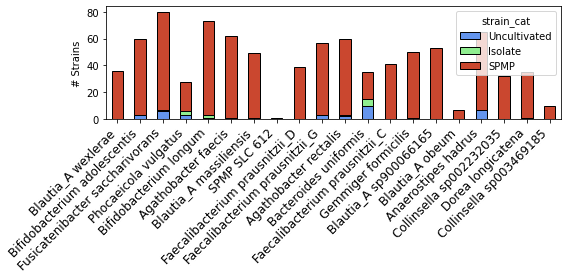

In [11]:
npal = ['#6495ed', '#90ee90', '#ca472f']

graph = Graph(sct)
graph.shs.stacked_barplot(x='label', y='count', hue='strain_cat', palette=npal, stack_order=['Uncultivated', 'Isolate', 'SPMP'], edgecolor="black", linewidth=1)
graph.ax.set_xlabel('')
graph.ax.set_ylabel('# Strains')
graph.apply_xticklabels(rotation=45, ha='right', size=12)

graph.set_size_inches(8, 4)
graph.tight_layout()
graph.save('../img/f2c.pdf')

In [12]:
count = sc_cat[sc_cat['spmp_found']].groupby('SLC_ID')['strain_cat'].value_counts().rename('count').reset_index()
count['species'] = count['SLC_ID'].map(minfo[~ minfo['species'].isnull()].set_index('SLCID')['species'].to_dict()).fillna('Unknown')

save_replace_excel_spmp(count, 'Fig 2.C')
count.head()

,SLC_ID,strain_cat,count,species
0,0,SPMP,32,Collinsella sp003459245
1,1,SPMP,3,CAG-81 sp900066785
2,2,SPMP,4,CAG-274 sp900545305
3,2,Uncultivated,3,CAG-274 sp900545305
4,3,SPMP,2,Unknown


## Supplementary figure 12

In [13]:
sct = sc_cat[(sc_cat['spmp_found'] == False) & (sc_cat['strain_cat'] == 'Isolate')]
sct = sct[sct['SLC_ID'].isin(slcids)]
sct = sct.groupby('SLC_ID')['strain_cat'].value_counts().rename('count').reset_index()

sct['label'] = sct['SLC_ID'].map(labels)
sct['label'] = pd.Categorical(sct['label'], categories=order)
sct.head(5)

,SLC_ID,strain_cat,count,label
0,0,Isolate,60,Collinsella sp002232035
1,26,Isolate,25,Blautia_A obeum
2,33,Isolate,18,Phocaeicola vulgatus
3,34,Isolate,35,Blautia_A wexlerae
4,35,Isolate,6,Blautia_A sp900066165


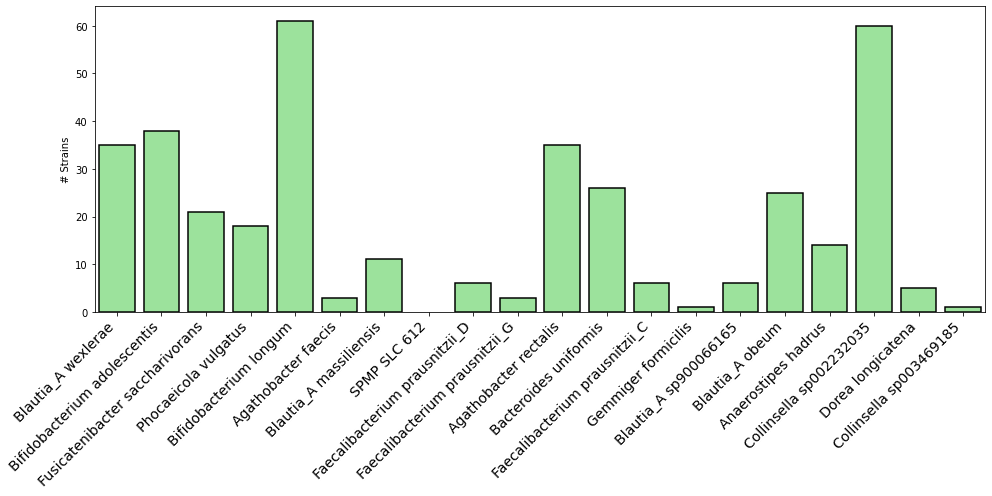

In [14]:
graph = Graph(sct)

graph.sns.barplot(x='label', y='count', edgecolor="black", linewidth=1.5, color=cpal[0])
graph.ax.set_xlabel('')
graph.ax.set_ylabel('# Strains')
graph.apply_xticklabels(rotation=45, ha='right', size=14)

graph.set_size_inches(14, 7)
graph.tight_layout()
graph.save('../img/sf12.A.pdf')

In [15]:
save_replace_excel_spmp(sct, 'SFig 12.A')
sct.head()

,SLC_ID,strain_cat,count,label
0,0,Isolate,60,Collinsella sp002232035
1,26,Isolate,25,Blautia_A obeum
2,33,Isolate,18,Phocaeicola vulgatus
3,34,Isolate,35,Blautia_A wexlerae
4,35,Isolate,6,Blautia_A sp900066165


### Tree generation

We generate the tree which will be drawn later with FigTree. This is a 2-steps process:
1. We generate a list of strains cluster representatives with preference for Isolate which will be compared using fastANI
2. We use fastANI distances to produce a NJ tree

We filter result to only conserve either:
1. Strain clusters which have a SPMP strain
2. UHGG only clusters which have an isolate

In [16]:
tree_sc = sc_cat[(sc_cat['spmp_found']) | (sc_cat['strain_cat'] == 'Isolate')]
tree_sc.head()

,SLC_ID,FusedCID,strain_cat,spmp_found
15,0,0_1010,Isolate,False
21,0,0_1016,Isolate,False
24,0,0_1019,Isolate,False
28,0,0_1022,Isolate,False
29,0,0_1023,SPMP,True


In [17]:
tree_sc[tree_sc['SLC_ID'] == 284][['strain_cat', 'spmp_found']].value_counts()

strain_cat    spmp_found
SPMP          True          70
Isolate       False         61
              True           2
Uncultivated  True           1
dtype: int64

In [18]:
def select_genome(sdf):
    if 'Isolate' in set(sdf['genome_cat']):
        sdf = sdf[sdf['genome_cat'] == 'Isolate']
    return list(sdf['genome'])[0]

def make_list(sc, df, cid):
    sdf = sc[sc['SLC_ID'] == cid]
    sdf = df[df['FusedCID'].isin(sdf['FusedCID'])]
    return sdf.groupby('FusedCID').apply(select_genome).to_dict()

# these genomes were sent for fastANI
# make_list(tree_sc, df, 280)
# make_list(tree_sc, df, 284)

Tree building using BioPython Phylo

In [19]:
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

In [20]:
fname = os.path.join('../tables/280.fastani.tsv.gz')

# BFM: bidirectional fragment mappings
# TQF: total query fragments
names = ['query', 'reference', 'similarity', 'BFM', 'TQF']
fani = pd.read_csv(fname, sep='\t', names=names, compression='gzip')

fani['query'] = fani['query'].apply(os.path.basename)
fani['reference'] = fani['reference'].apply(os.path.basename)

dfmatrix = pd.pivot_table(fani, index='query', columns='reference', values='similarity')
dfmatrix = 100 - dfmatrix

matrix = [value[:idx+1]
    for idx, value in enumerate(dfmatrix.values.tolist())]

dm = DistanceMatrix(list(dfmatrix.columns), matrix)

calculator = DistanceCalculator('identity')
tree = DistanceTreeConstructor(calculator).nj(dm)

for clade in tree.get_nonterminals() :
    if np.isnan(clade.branch_length):
        clade.branch_length = 0
        
for clade in tree.get_terminals() :
    if np.isnan(clade.branch_length):
        clade.branch_length = 0

tree_fname = '../tmp/strains_tree/280.tree.newick'
# Phylo.write(tree, tree_fname, "newick")

tree

Tree(rooted=False)

In [21]:
fname = os.path.join('../tables/280.fastani.tsv.gz')

# BFM: bidirectional fragment mappings
# TQF: total query fragments
names = ['query', 'reference', 'similarity', 'BFM', 'TQF']
fani = pd.read_csv(fname, sep='\t', names=names, compression='gzip')

fani['query'] = fani['query'].apply(os.path.basename)
fani['reference'] = fani['reference'].apply(os.path.basename)

dfmatrix = pd.pivot_table(fani, index='query', columns='reference', values='similarity')
dfmatrix = 100 - dfmatrix

save_replace_excel_spmp(dfmatrix, 'SFig 12.B280')
dfmatrix.head()

reference,GUT_GENOME000099.fa,GUT_GENOME000144.fa,GUT_GENOME000194.fa,GUT_GENOME000437.fa,GUT_GENOME000538.fa,GUT_GENOME000702.fa,GUT_GENOME000842.fa,GUT_GENOME000861.fa,GUT_GENOME001121.fa,GUT_GENOME001293.fa,...,TLL78_bin.4.fasta,TLL83_bin.3.fasta,TLL84_bin.111.fasta,TLL86_bin.6.fasta,TLL91_bin.43.fasta,TLL93_bin.71.fasta,TLL94_bin.37.fasta,TLL96_bin.9.fasta,TLL97_bin.18.fasta,TLL99_bin.102.fasta
query,,,,,,,,,,,,,,,,,,,,,
GUT_GENOME000099.fa,0.0001,1.7857,1.4157,1.6213,1.6439,1.7377,2.1255,2.1127,1.8792,1.8867,...,2.0630,1.5969,2.0785,1.6873,2.4294,1.7672,1.8072,2.2066,2.2226,2.0030
GUT_GENOME000144.fa,1.7232,0.0000,1.5467,1.6384,1.6553,1.5442,1.6971,2.0023,1.8757,1.9933,...,1.9722,1.4538,1.9904,1.6125,2.2012,1.7987,1.8222,1.9982,1.7954,1.8354
GUT_GENOME000194.fa,1.3889,1.5858,0.0000,1.5310,1.5461,1.7552,1.7551,1.8066,1.6564,1.8099,...,1.9514,1.5209,1.8741,1.7590,2.0878,1.5999,1.6003,2.0396,1.5428,1.8270
GUT_GENOME000437.fa,1.4155,1.6641,1.5694,0.0000,1.6415,1.5749,1.7073,1.8354,1.6779,1.7979,...,1.7247,1.3119,2.0783,1.5618,1.9718,1.3852,1.5902,1.8368,1.2962,1.6724
GUT_GENOME000538.fa,1.5305,1.5730,1.5253,1.6785,0.0000,1.5601,1.8346,1.9430,1.6028,1.8268,...,1.9768,1.5385,1.9652,1.6682,2.3754,1.6949,1.7348,1.8540,2.0081,1.6975


In [22]:
fname = os.path.join('../tables/284.fastani.tsv.gz')

# BFM: bidirectional fragment mappings
# TQF: total query fragments
names = ['query', 'reference', 'similarity', 'BFM', 'TQF']
fani = pd.read_csv(fname, sep='\t', names=names, compression='gzip')

fani['query'] = fani['query'].apply(os.path.basename)
fani['reference'] = fani['reference'].apply(os.path.basename)

dfmatrix = pd.pivot_table(fani, index='query', columns='reference', values='similarity')
dfmatrix = 100 - dfmatrix

save_replace_excel_spmp(dfmatrix, 'SFig 12.B284')
dfmatrix.head()

reference,GUT_GENOME000041.fa,GUT_GENOME000436.fa,GUT_GENOME000562.fa,GUT_GENOME000679.fa,GUT_GENOME000744.fa,GUT_GENOME000749.fa,GUT_GENOME000761.fa,GUT_GENOME000769.fa,GUT_GENOME000780.fa,GUT_GENOME000832.fa,...,TLL83_bin.30.fasta,TLL84_bin.19.fasta,TLL86_bin.30.fasta,TLL88_bin.76.fasta,TLL89_bin.111.fasta,TLL94_bin.52.fasta,TLL95_bin.56.fasta,TLL96_bin.81.fasta,TLL97_bin.87.fasta,TLL99_bin.67.fasta
query,,,,,,,,,,,,,,,,,,,,,
GUT_GENOME000041.fa,0.0000,1.4719,1.3526,1.3951,1.2890,1.2712,1.3139,1.3416,1.4308,1.3253,...,1.5995,1.6300,1.3707,1.3147,1.3151,2.1219,1.4026,1.4005,1.8366,1.3496
GUT_GENOME000436.fa,1.3815,0.0000,1.4162,1.5969,1.3540,1.2627,1.2216,1.3221,1.2207,1.6086,...,1.3020,1.7424,1.2215,1.4327,1.2467,2.2354,1.3887,1.4484,1.7906,1.3169
GUT_GENOME000562.fa,1.3241,1.3314,0.0000,1.3928,1.2609,1.2425,1.4476,1.3964,1.1944,1.3173,...,1.5340,1.8433,1.5101,1.3606,1.4068,2.1749,1.5349,1.3144,1.8761,1.4009
GUT_GENOME000679.fa,1.3853,1.6364,1.4167,0.0000,1.5334,1.4665,1.8002,1.5140,1.4685,1.5676,...,1.7735,1.9182,1.7938,1.6418,1.4834,2.2650,1.4408,1.6184,1.8866,1.6560
GUT_GENOME000744.fa,1.2227,1.3460,1.3308,1.4570,0.0000,1.2786,1.2742,1.0525,1.4153,1.3936,...,1.4605,1.6389,1.2458,1.4883,1.2166,2.2016,1.3185,1.3457,1.8871,1.5640
